In [21]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import flax
from typing import Sequence

In [35]:
class SimpleMLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        """Defines the forward pass of the MLP.

        Args:
            x: The input array. Shape (n_batch, n_features_in).

        Returns:
            The output of the network. Shape (n_batch, n_features_out).
        """
        # All but the last layer get a ReLU activation function
        for i, feat in enumerate(self.features[:-1]):
            x = nn.Dense(features=feat)(x)
            x = nn.swish(x)

        # The final layer is the output layer
        x = nn.Dense(features=self.features[-1])(x)
        return x

In [36]:
key = jax.random.key(0)

# 1. Instantiate the model (the "blueprint")
# This MLP will have two hidden layers (64, 32) and one output layer (10)
model = SimpleMLP(features=[128, 1])
print(f"Model architecture:\n{model}\n")

# 2. Initialize the parameters
# We need a key for random weight initialization and a dummy input
# to tell Flax the input shape.
dummy_input = jnp.ones((1, 28 * 28))  # e.g., one flattened 28x28 image
params = model.init(key, dummy_input)["params"]

# The `params` object is a nested dictionary ("pytree")
print("--- Parameter Shapes ---")
print(jax.tree_util.tree_map(lambda x: x.shape, params))
print("-" * 25)

# 3. Perform a forward pass (the "apply" step)
# Create some random input data
input_data = jnp.ones((128, 28 * 28))  # A batch of 128 inputs
output = model.apply({"params": params}, input_data)

print(f"\nInput shape: {input_data.shape}")
print(f"Output shape: {output.shape}")

Model architecture:
SimpleMLP(
    # attributes
    features = [128, 1]
)

--- Parameter Shapes ---
{'Dense_0': {'bias': (128,), 'kernel': (784, 128)}, 'Dense_1': {'bias': (1,), 'kernel': (128, 1)}}
-------------------------

Input shape: (128, 784)
Output shape: (128, 1)


In [34]:
params

{'params': {'bias': Array([-2.4378996 , -2.07345   ,  0.18866651, -0.34174547, -0.77294886],      dtype=float32),
  'kernel': Array([[ 0.99648714, -0.84069055, -0.7420563 , -1.1751673 , -0.88212633],
         [ 0.5849409 ,  0.6981158 , -1.0097519 ,  1.6940992 , -1.9293189 ],
         [-1.2534724 ,  0.19594063, -1.1317803 ,  0.23212159,  1.7384187 ],
         [ 0.54630667,  0.62694055, -0.4886673 ,  0.9249355 ,  0.3472473 ],
         [-0.6366119 , -0.96825767,  0.77167565,  1.0612171 ,  0.9169658 ],
         [-0.46407035,  0.8665426 ,  1.6763489 , -2.526709  ,  0.4433026 ],
         [ 1.8060067 , -1.2587421 , -0.57777286,  2.2216108 ,  0.76148087],
         [-0.21333523, -1.6236352 , -0.8071298 , -2.3925495 ,  1.5795202 ],
         [ 1.4050099 ,  0.34845546,  0.02730806,  1.1249974 , -0.21001515],
         [-0.30623946,  0.7411661 , -0.3360593 ,  0.46161816,  0.19004533]],      dtype=float32)}}

In [37]:
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state
from typing import Sequence, Callable, Tuple


# Use the SimpleMLP class from Example 1
class SimpleMLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for i, feat in enumerate(self.features[:-1]):
            x = nn.Dense(features=feat)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.features[-1])(x)
        return x


class TrainState(train_state.TrainState):
    """A custom TrainState to also hold a loss function."""

    loss_fn: Callable


def create_train_state(
    model: nn.Module, key: jnp.ndarray, learning_rate: float, dummy_input: jnp.ndarray
) -> TrainState:
    """Creates initial TrainState."""
    params = model.init(key, dummy_input)["params"]
    tx = optax.adam(learning_rate)

    def mse_loss(p, batch):
        x, y = batch
        preds = model.apply({"params": p}, x)
        loss = jnp.mean((preds - y) ** 2)
        return loss

    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx, loss_fn=mse_loss
    )


@jax.jit
def train_step(state: TrainState, batch: Tuple[jnp.ndarray, jnp.ndarray]):
    """Performs a single training step."""
    grad_fn = jax.value_and_grad(state.loss_fn)
    loss, grads = grad_fn(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss


def main_training():
    """Demonstrates a full training loop."""
    key = jax.random.PRNGKey(42)
    data_key, model_key = jax.random.split(key)

    # 1. Create a synthetic dataset (y = 5x + 2 + noise)
    n_samples = 100
    x_data = jax.random.uniform(data_key, (n_samples, 1), minval=-2, maxval=2)
    noise = 0.5 * jax.random.normal(data_key, (n_samples, 1))
    y_data = 5 * x_data + 2 + noise

    # 2. Create the model and TrainState
    model = SimpleMLP(features=[64, 1])
    state = create_train_state(model, model_key, 0.01, dummy_input=jnp.ones((1, 1)))

    # 3. The training loop
    n_epochs = 20
    batch_size = 10
    n_steps_per_epoch = n_samples // batch_size

    print("--- Starting Training ---")
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for _ in range(n_steps_per_epoch):
            # This is a simple way to batch; for large datasets,
            # use tf.data or other data loading libraries.
            perms = jax.random.permutation(key, n_samples)
            batch_indices = perms[:batch_size]
            batch = (x_data[batch_indices], y_data[batch_indices])
            state, loss = train_step(state, batch)
            epoch_loss += loss

        avg_loss = epoch_loss / n_steps_per_epoch
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:02d}, Avg Loss: {avg_loss:.4f}")

    print("--- Training Complete ---")
    final_params = state.params
    print("Final learned 'kernel' (weight) of first layer:")
    print(final_params["Dense_0"]["kernel"])


if __name__ == "__main__":
    # main() # From Example 1
    main_training()

--- Starting Training ---


TypeError: Error interpreting argument to <function train_step at 0x155e7c9d0> as an abstract array. The problematic value is of type <class 'function'> and was passed to the function at path state.loss_fn.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

In [52]:
from flax import nnx
import optax


class Model(nnx.Module):
    def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
        self.linear = nnx.Linear(din, dmid, rngs=rngs)
        self.bn = nnx.BatchNorm(dmid, rngs=rngs)
        self.dropout = nnx.Dropout(0.2, rngs=rngs)
        self.linear_out = nnx.Linear(dmid, dout, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.dropout(self.bn(self.linear(x))))
        return self.linear_out(x)


model = Model(2, 64, 3, rngs=nnx.Rngs(0))  # eager initialization
optimizer = nnx.Optimizer(model, optax.adam(1e-3), wrt=nnx.Param)


@nnx.jit  # automatic state management for JAX transforms
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)  # call methods directly
        return ((y_pred - y) ** 2).mean()

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # in-place updates

    return loss


train_step(model, optimizer, jnp.ones((16, 2)), jnp.ones((16, 3)))

Array(1.0000029, dtype=float32)

--- Starting Training ---
Epoch 010 | Loss: 0.3340
Epoch 020 | Loss: 0.2575
Epoch 030 | Loss: 0.1816
Epoch 040 | Loss: 0.1143
Epoch 050 | Loss: 0.0652
Epoch 060 | Loss: 0.0354
Epoch 070 | Loss: 0.0205
Epoch 080 | Loss: 0.0123
Epoch 090 | Loss: 0.0073
Epoch 100 | Loss: 0.0046
--- Training Complete ---


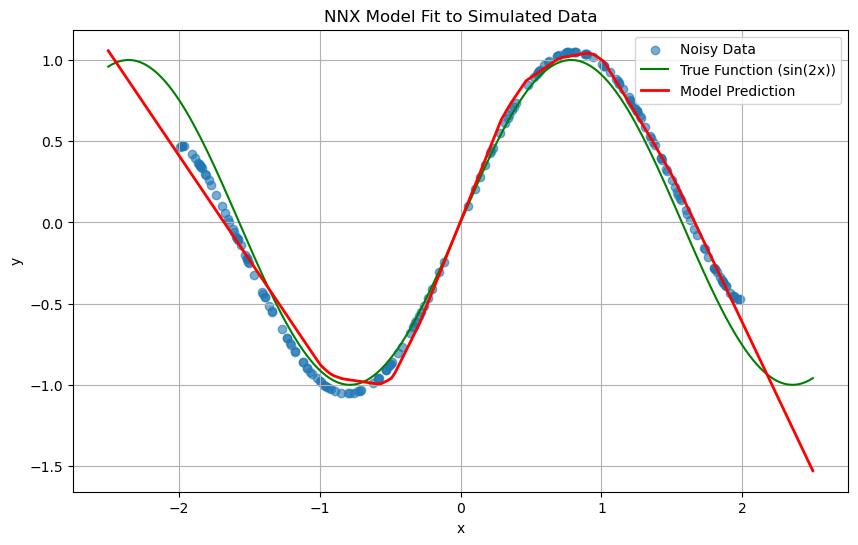

In [55]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import nnx
from typing import Tuple

# ##############################################################################
# 1. Define the Model Architecture
# ##############################################################################


class MLP(nnx.Module):
    """A simple Multi-Layer Perceptron using nnx."""

    def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
        """Initializes the MLP layers.

        Args:
            din: The number of input dimensions.
            dmid: The number of neurons in the hidden layer.
            dout: The number of output dimensions.
            rngs: The random number generator keys for initialization.
        """
        self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
        self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        """Defines the forward pass of the network.

        Args:
            x: The input data. Shape (n_batch, din).

        Returns:
            The output of the network. Shape (n_batch, dout).
        """
        x = self.linear1(x)
        x = nnx.relu(x)
        x = self.linear2(x)
        return x


# ##############################################################################
# 2. Define the JIT-compiled Training Step
# ##############################################################################


@nnx.jit
def train_step(
    model: MLP, optimizer: nnx.Optimizer, batch: Tuple[jax.Array, jax.Array]
) -> Tuple[jax.Array, MLP]:
    """Performs a single, JIT-compiled training step.

    Args:
        model: The nnx model to train.
        optimizer: The nnx optimizer.
        batch: A tuple containing the input data (x) and target data (y).

    Returns:
        A tuple containing:
        - The loss for the current step.
        - The updated model.
    """
    x, y = batch

    def loss_fn(model: MLP) -> jax.Array:
        """Calculates the loss for a given model."""
        y_pred = model(x)
        # Ensure y_pred and y have compatible shapes for subtraction
        loss = jnp.mean((y_pred - y.reshape(-1, 1)) ** 2)
        return loss

    # Calculate gradients of the loss with respect to the model's parameters.
    grads = nnx.grad(loss_fn)(model)
    # Update the model's parameters in-place using the optimizer.
    optimizer.update(grads)

    # For logging, we can re-compute the loss with the updated model.
    # Note: value_and_grad is also an option, but this is clear.
    loss = loss_fn(model)
    return loss, model


# ##############################################################################
# 3. Main Script Logic
# ##############################################################################

if __name__ == "__main__":
    # --- 3.1. Setup and Data Simulation ---
    key = jax.random.key(0)
    data_key, model_key = jax.random.split(key)

    # Create synthetic data for a sine wave
    n_samples = 200
    x_data = jax.random.uniform(data_key, (n_samples,), minval=-2, maxval=2)
    # Add some noise to the target
    noise = 0.1 * jax.random.normal(data_key, (n_samples,))
    y_data = jnp.sin(2 * x_data) + noise

    # Reshape data for batching (add a feature dimension)
    x_data = x_data.reshape(-1, 1)

    # --- 3.2. Model and Optimizer Initialization ---
    # Eagerly initialize the model. It's ready to use immediately.
    model = MLP(din=1, dmid=32, dout=1, rngs=nnx.Rngs(model_key))

    # Create an optimizer linked to the model's parameters (`nnx.Param`).
    optimizer = nnx.Optimizer(model, optax.adam(learning_rate=1e-2))

    # --- 3.3. The Training Loop ---
    n_epochs = 100
    print("--- Starting Training ---")
    for epoch in range(n_epochs):
        # In this simple example, we use the full dataset as one batch.
        batch = (x_data, y_data)
        loss, model = train_step(model, optimizer, batch)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d} | Loss: {loss:.4f}")

    print("--- Training Complete ---")

    # --- 3.4. Visualization ---
    # Create a smooth set of points for plotting the learned function
    x_continuous = jnp.linspace(-2.5, 2.5, 200).reshape(-1, 1)
    y_pred = model(x_continuous)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, label="Noisy Data", alpha=0.6)
    plt.plot(
        x_continuous, jnp.sin(2 * x_continuous), "g-", label="True Function (sin(2x))"
    )
    plt.plot(x_continuous, y_pred, "r-", label="Model Prediction", linewidth=2)
    plt.title("NNX Model Fit to Simulated Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

Initial params: shift=0.0000, scale=1.0000
Step 010 | NLL Loss: 3.6195
Step 020 | NLL Loss: 2.8258
Step 030 | NLL Loss: 2.7872
Step 040 | NLL Loss: 2.7783
Step 050 | NLL Loss: 2.7486
Step 060 | NLL Loss: 2.7056
Step 070 | NLL Loss: 2.6573
Step 080 | NLL Loss: 2.6068
Step 090 | NLL Loss: 2.5543
Step 100 | NLL Loss: 2.4991
Step 110 | NLL Loss: 2.4407
Step 120 | NLL Loss: 2.3798
Step 130 | NLL Loss: 2.3180
Step 140 | NLL Loss: 2.2581
Step 150 | NLL Loss: 2.2038
Step 160 | NLL Loss: 2.1591
Step 170 | NLL Loss: 2.1271
Step 180 | NLL Loss: 2.1082
Step 190 | NLL Loss: 2.0995
Step 200 | NLL Loss: 2.0967
Step 210 | NLL Loss: 2.0961
Step 220 | NLL Loss: 2.0961
Step 230 | NLL Loss: 2.0961
Step 240 | NLL Loss: 2.0960
Step 250 | NLL Loss: 2.0960
Step 260 | NLL Loss: 2.0960
Step 270 | NLL Loss: 2.0960
Step 280 | NLL Loss: 2.0960
Step 290 | NLL Loss: 2.0960
Step 300 | NLL Loss: 2.0960
Step 310 | NLL Loss: 2.0960
Step 320 | NLL Loss: 2.0960
Step 330 | NLL Loss: 2.0960
Step 340 | NLL Loss: 2.0960
Step 

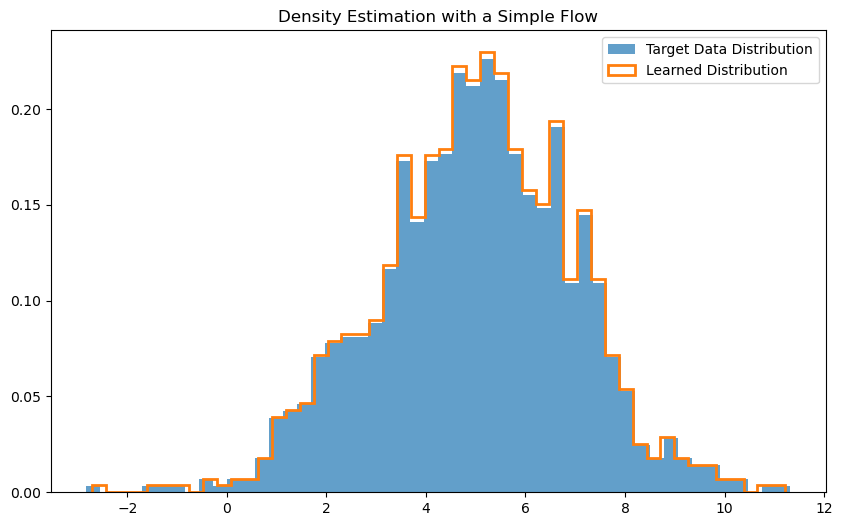

In [67]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import nnx
from jax.scipy.stats import norm
from typing import Tuple


class Affine(nnx.Module):
    """A simple affine bijector.

    This module performs the transformation y = x * scale + shift.
    """

    def __init__(self, *, rngs: nnx.Rngs):
        """Initializes the scale and shift parameters."""
        # We learn the log_scale to ensure scale is always positive.
        self.log_scale = nnx.Param(jnp.zeros(()))
        self.shift = nnx.Param(jnp.zeros(()))

    @property
    def scale(self) -> jax.Array:
        """The positive scaling factor."""
        return jnp.exp(self.log_scale)

    def forward(self, x: jax.Array) -> jax.Array:
        """Computes the forward transformation (for sampling).

        Args:
            x: The input array from the base distribution (z).

        Returns:
            The transformed array (y).
        """
        return x * self.scale + self.shift

    def inverse(self, y: jax.Array) -> jax.Array:
        """Computes the inverse transformation (for density estimation).

        Args:
            y: The input array from the data distribution (x).

        Returns:
            The inverse-transformed array (z).
        """
        return (y - self.shift) / self.scale

    def log_det_jacobian(self, x: jax.Array) -> jax.Array:
        """Computes the log of the absolute Jacobian determinant.

        For the transformation y = ax + b, the Jacobian is dy/dx = a.
        The log-determinant is therefore log|a|, which is just log_scale.

        Args:
            x: The input array (unused, as Jacobian is constant).

        Returns:
            The log-determinant.
        """
        # The determinant is constant for this simple transformation
        return self.log_scale


@nnx.jit
def train_step(model: Affine, optimizer: nnx.Optimizer, x: jax.Array) -> jax.Array:
    """Performs one training step to minimize the NLL."""

    def loss_fn(model: Affine) -> jax.Array:
        # --- YOUR CODE GOES HERE ---
        # TODO: Implement the Negative Log-Likelihood (NLL) loss.
        # The formula is: NLL = -log_probability
        # log_probability = log_base_pdf + log_det_jacobian
        #
        # Steps:
        # 1. Apply the inverse transformation to map data `x` back to the base `z`.
        # 2. Get the log-determinant of the Jacobian from the model.
        # 3. Calculate the log-pdf of `z` under the base distribution
        #    (a standard normal distribution: loc=0, scale=1).
        #    Use `jax.scipy.stats.norm.logpdf(z, loc=0, scale=1)`.
        # 4. Sum the log-pdf and the log-determinant to get the log-probability.
        # 5. Return the *negative* of the *mean* log-probability (this is the NLL).

        # Placeholder:
        z = model.inverse(x)
        log_det = model.log_det_jacobian(x)
        log_prob_z = norm.logpdf(z, loc=0.0, scale=1.0)
        log_prob_x = log_prob_z - log_det
        return -jnp.mean(log_prob_x)
        # --- END OF YOUR CODE ---

    grads = nnx.grad(loss_fn)(model)
    optimizer.update(grads)
    return loss_fn(model)


if __name__ == "__main__":
    key = jax.random.key(0)

    # 1. Create the target dataset
    target_mean, target_std = 5.0, 2.0
    x_data = target_std * jax.random.normal(key, (1000,)) + target_mean

    # 2. Initialize the model and optimizer
    model = Affine(rngs=nnx.Rngs(0))
    optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.1))

    print(
        f"Initial params: shift={model.shift.value:.4f}, scale={model.scale:.4f}"
    )

    # 3. Training loop
    for i in range(500):
        loss = train_step(model, optimizer, x_data)
        if (i + 1) % 10 == 0:
            print(f"Step {i+1:03d} | NLL Loss: {loss:.4f}")

    print(
        f"Final learned params: shift={model.shift.value:.4f}, scale={model.scale:.4f}"
    )
    print(f"Target params:      shift={target_mean:.4f}, scale={target_std:.4f}")

    # 4. Visualization
    plt.figure(figsize=(10, 6))
    plt.hist(x_data, bins=50, density=True, label="Target Data Distribution", alpha=0.7)

    # Plot the learned distribution
    z_samples = jax.random.normal(key, (1000,))
    x_learned = model.forward(z_samples)
    plt.hist(
        x_learned,
        bins=50,
        density=True,
        label="Learned Distribution",
        histtype="step",
        linewidth=2,
    )

    plt.legend()
    plt.title("Density Estimation with a Simple Flow")
    plt.show()

In [60]:
model.shift.value

Array(0., dtype=float32)

In [62]:
model.scale

Array(1., dtype=float32)

In [68]:
from flax import nnx
import jax
import jax.numpy as jnp
from typing import Sequence, Tuple


# We can re-use the MLP from our previous example
class MLP(nnx.Module):
    def __init__(self, features: Sequence[int], *, rngs: nnx.Rngs):
        self.layers = [
            nnx.Linear(din, dout, rngs=rngs)
            for din, dout in zip(features[:-1], features[1:])
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers[:-1]:
            x = nnx.relu(layer(x))
        x = self.layers[-1](x)
        return x


class AffineCouplingLayer(nnx.Module):
    """An affine coupling layer for a normalizing flow."""

    def __init__(
        self,
        din: int,
        dmid: int,
        *,
        rngs: nnx.Rngs,
        reverse_mask: bool = False,
    ):
        """Initializes the coupling layer.

        Args:
            din: The input dimension of the data.
            dmid: The hidden dimension of the conditioner MLP.
            rngs: The random keys for initialization.
            reverse_mask: A boolean to determine which part of the data
                          to transform.
        """

        self.din = din
        self.reverse_mask = reverse_mask

        # The conditioner network that produces scale and shift
        # It outputs 2 * (half the dimension)
        self.conditioner = MLP(
            features=[self.din // 2, dmid, self.din - self.din // 2], rngs=rngs
        )

    def forward(self, x: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """The forward pass (used for sampling). z -> x"""
        x_a, x_b = jnp.split(x, 2, axis=-1)  # Split the input into two halves

        if self.reverse_mask:
            x_a, x_b = x_b, x_a  # Reverse the split

        # The conditioner only sees the first half of the data
        s_and_t = self.conditioner(x_a)  # Get (log) scale and shift from the conditioner
        log_s, t = jnp.split(s_and_t, 2, axis=-1)  # Split the output into (log) scale and shift

        # Stabilize the scaling factor
        s = jnp.tanh(log_s) # Scale is now in (-1, 1)

        # The second half is transformed
        y_b = x_b * jnp.exp(s) + t # affine transformation (exponentiate the log scale to get the scale)

        if self.reverse_mask:
            x_a, y_b = y_b, x_a  # Reverse the split

        y = jnp.concatenate([x_a, y_b], axis=-1)
        log_det = s.sum(axis=-1)

        return y, log_det

    def inverse(self, y: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """The inverse pass (used for density estimation). x -> z"""
        y_a, y_b = jnp.split(y, 2, axis=-1)

        if self.reverse_mask:
            y_a, y_b = y_b, y_a

        s_and_t = self.conditioner(y_a)
        log_s, t = jnp.split(s_and_t, 2, axis=-1)

        s = jnp.tanh(log_s)

        # Invert the transformation
        x_b = (y_b - t) * jnp.exp(-s)

        if self.reverse_mask:
            y_a, x_b = x_b, y_a

        x = jnp.concatenate([y_a, x_b], axis=-1)
        log_det = s.sum(axis=-1)

        return x, log_det

In [79]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import nnx
from sklearn.datasets import make_moons
from typing import List


class MLP(nnx.Module):
    def __init__(self, features: Sequence[int], *, rngs: nnx.Rngs):
        self.layers = [
            nnx.Linear(din, dout, rngs=rngs)
            for din, dout in zip(features[:-1], features[1:])
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers[:-1]:
            x = nnx.relu(layer(x))
        x = self.layers[-1](x)
        return x


class AffineCouplingLayer(nnx.Module):
    """An affine coupling layer for a normalizing flow."""

    def __init__(
        self, din: int, dmid: int, *, rngs: nnx.Rngs, reverse_mask: bool = False
    ):
        self.din = din
        # Determine the size of the part that remains unchanged (identity)
        # This handles both even and odd input dimensions correctly.
        self.identity_size = din // 2
        transform_size = din - self.identity_size
        self.reverse_mask = reverse_mask

        # Conditioner's input size is the identity part, output size must
        # produce scale and shift for the transform part.
        self.conditioner = MLP(
            features=[self.identity_size, dmid, transform_size * 2], rngs=rngs
        )

    def _get_split_parts(self, x: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """Splits data into identity and transform parts based on the mask."""
        identity, transform = jnp.split(x, [self.identity_size], axis=-1)
        if self.reverse_mask:
            return transform, identity
        return identity, transform

    def forward(self, x: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """z -> x"""
        identity_part, transform_part = self._get_split_parts(x)

        s_and_t = self.conditioner(identity_part)
        log_s, t = jnp.split(s_and_t, 2, axis=-1)
        s = jnp.tanh(log_s)  # Stabilize the scale

        transformed_part = transform_part * jnp.exp(s) + t

        if self.reverse_mask:
            y = jnp.concatenate([transformed_part, identity_part], axis=-1)
        else:
            y = jnp.concatenate([identity_part, transformed_part], axis=-1)

        log_det = s.sum(axis=-1)
        return y, log_det

    def inverse(self, y: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """x -> z"""
        identity_part, transform_part = self._get_split_parts(y)

        s_and_t = self.conditioner(identity_part)
        log_s, t = jnp.split(s_and_t, 2, axis=-1)
        s = jnp.tanh(log_s)

        transformed_part_inv = (transform_part - t) * jnp.exp(-s)

        if self.reverse_mask:
            x = jnp.concatenate([transformed_part_inv, identity_part], axis=-1)
        else:
            x = jnp.concatenate([identity_part, transformed_part_inv], axis=-1)

        log_det = s.sum(axis=-1)
        return x, log_det


class NormalizingFlow(nnx.Module):
    """A stack of bijectors to create a normalizing flow."""

    def __init__(self, num_layers: int, din: int, dmid: int, *, rngs: nnx.Rngs):
        self.din = din
        keys = jax.random.split(rngs.params(), num_layers)
        self.layers = [
            AffineCouplingLayer(
                din, dmid, rngs=nnx.Rngs(keys[i]), reverse_mask=i % 2 == 1
            )
            for i in range(num_layers)
        ]

    def log_prob(self, x: jax.Array) -> jax.Array:
        """Calculates the log probability of the data."""
        # --- YOUR CODE GOES HERE ---
        # TODO: Implement the log probability calculation.
        # The formula is: log_p(x) = log_p(z) - total_log_det
        #
        # Steps:
        # 1. Initialize a `total_log_det` to zero.
        # 2. Loop through your layers in *reverse order*.
        # 3. In each iteration, apply the layer's `inverse` method to `x`.
        #    This will give you the new `x` and the layer's `log_det`.
        # 4. Add the `log_det` to your `total_log_det`.
        # 5. After the loop, the final `x` is your `z`.
        # 6. Calculate the log probability of `z` under a standard normal
        #    base distribution. The log_pdf for a multivariate Gaussian
        #    is the sum of the log_pdfs for each dimension.
        # 7. Return the final log probability for each data point.
        # --- END OF YOUR CODE ---
        total_log_det = 0.0
        for layer in self.layers[::-1]:
            x, log_det = layer.inverse(x)
            total_log_det += log_det
        z = x # just for clarity
        log_p_z = norm.logpdf(z, loc=0.0, scale=1.0).sum(axis=-1)
        return log_p_z - total_log_det

    def sample(self, num_samples: int, *, rngs: nnx.Rngs) -> jax.Array:
        """Generates new samples from the flow."""
        # --- YOUR CODE GOES HERE ---
        # TODO: Implement the sampling procedure.
        #
        # Steps:
        # 1. Generate `z` samples from a standard normal distribution.
        #    Use `jax.random.normal(rngs.next(), (num_samples, self.din))`.
        # 2. Loop through your layers in *forward order*.
        # 3. Apply the `forward` method of each layer to transform the samples.
        # 4. Return the final transformed samples.
        # --- END OF YOUR CODE ---
        z = jax.random.normal(rngs.next(), (num_samples, self.din))
        for layer in self.layers:
            z, _ = layer.forward(z)

        return z


# The train_step and main script would follow, which we can fill in after
# you complete the NormalizingFlow model.

--- Starting Training ---
Step 0000 | NLL Loss: 29.9496
Step 0500 | NLL Loss: 0.9417
Step 1000 | NLL Loss: 0.7255
Step 1500 | NLL Loss: 0.7044
Step 2000 | NLL Loss: 0.6401
--- Training Complete ---


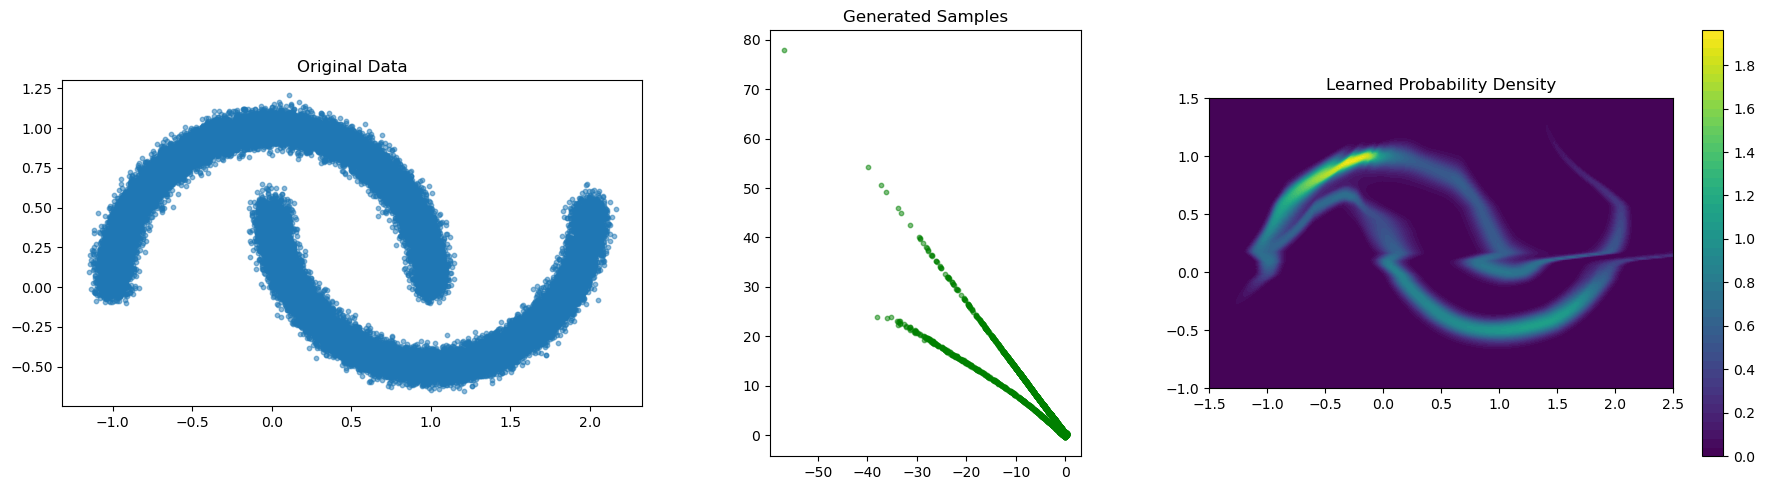

In [82]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import nnx
from sklearn.datasets import make_moons
from typing import List, Sequence, Tuple

# ##############################################################################
# 1. Model Components (You've already built these!)
# ##############################################################################


class MLP(nnx.Module):
    """A simple Multi-Layer Perceptron using nnx."""

    def __init__(self, features: Sequence[int], *, rngs: nnx.Rngs):
        self.layers = [
            nnx.Linear(din, dout, rngs=rngs)
            for din, dout in zip(features[:-1], features[1:])
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers[:-1]:
            x = nnx.relu(layer(x))
        x = self.layers[-1](x)
        return x


class AffineCouplingLayer(nnx.Module):
    """An affine coupling layer for a normalizing flow."""

    def __init__(
        self, din: int, dmid: int, *, rngs: nnx.Rngs, reverse_mask: bool = False
    ):
        self.din = din
        self.d_in_half = din // 2
        self.d_out_half = din - self.d_in_half
        self.reverse_mask = reverse_mask
        self.conditioner = MLP(
            features=[self.d_in_half, dmid, self.d_out_half * 2], rngs=rngs
        )

    def forward(self, x: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """z -> x"""
        x_a, x_b = jnp.split(x, [self.d_in_half], axis=-1)
        if self.reverse_mask:
            x_a, x_b = x_b, x_a

        s_and_t = self.conditioner(x_a)
        log_s, t = jnp.split(s_and_t, 2, axis=-1)
        s = jnp.tanh(log_s)

        y_b = x_b * jnp.exp(s) + t

        if self.reverse_mask:
            y_a, y_b = x_a, y_b
        else:
            y_a = x_a

        y = jnp.concatenate([y_a, y_b], axis=-1)
        log_det = s.sum(axis=-1)
        return y, log_det

    def inverse(self, y: jax.Array) -> Tuple[jax.Array, jax.Array]:
        """x -> z"""
        y_a, y_b = jnp.split(y, [self.d_in_half], axis=-1)
        if self.reverse_mask:
            y_a, y_b = y_b, y_a

        s_and_t = self.conditioner(y_a)
        log_s, t = jnp.split(s_and_t, 2, axis=-1)
        s = jnp.tanh(log_s)

        x_b = (y_b - t) * jnp.exp(-s)

        if self.reverse_mask:
            x_a, x_b = y_a, x_b
        else:
            x_a = y_a

        x = jnp.concatenate([x_a, x_b], axis=-1)
        log_det = s.sum(axis=-1)
        return x, log_det


class NormalizingFlow(nnx.Module):
    """A stack of bijectors to create a normalizing flow."""

    def __init__(self, num_layers: int, din: int, dmid: int, *, rngs: nnx.Rngs):
        self.din = din
        keys = jax.random.split(rngs.params(), num_layers)
        self.layers = [
            AffineCouplingLayer(
                din, dmid, rngs=nnx.Rngs(keys[i]), reverse_mask=i % 2 == 1
            )
            for i in range(num_layers)
        ]

    def log_prob(self, x: jax.Array) -> jax.Array:
        """Calculates the log probability of the data."""
        total_log_det = jnp.zeros(x.shape[0])
        for layer in self.layers[::-1]:
            x, log_det = layer.inverse(x)
            total_log_det += log_det

        z = x
        log_p_z = jax.scipy.stats.norm.logpdf(z).sum(axis=-1)
        return log_p_z - total_log_det

    def sample(self, num_samples: int, *, rngs: nnx.Rngs) -> jax.Array:
        """Generates new samples from the flow."""
        z = jax.random.normal(rngs.next(), (num_samples, self.din))
        for layer in self.layers:
            z, _ = layer.forward(z)
        return z


# ##############################################################################
# 2. Training Step and Main Script
# ##############################################################################


@nnx.jit
def train_step(
    model: NormalizingFlow, optimizer: nnx.Optimizer, batch: jax.Array
) -> jax.Array:
    """Performs a single training step."""

    def loss_fn(model: NormalizingFlow) -> jax.Array:
        # The loss is the negative mean log-probability of the data
        log_probs = model.log_prob(batch)
        return -jnp.mean(log_probs)

    grads = nnx.grad(loss_fn)(model)
    optimizer.update(grads)
    return loss_fn(model)


if __name__ == "__main__":
    # --- 1. Setup ---
    key = jax.random.key(42)
    model_key, sample_key = jax.random.split(key)

    # --- 2. Load Data ---
    x_data, _ = make_moons(n_samples=50_000, noise=0.05)

    # --- 3. Initialize Model and Optimizer ---
    flow = NormalizingFlow(num_layers=8, din=2, dmid=64, rngs=nnx.Rngs(model_key))
    optimizer = nnx.Optimizer(
        flow,
        optax.chain(
            optax.clip_by_global_norm(1.0), # Clip gradients to max norm of 1.0
            optax.adam(learning_rate=1e-3),
        )
    )

    # --- 4. Training Loop ---
    print("--- Starting Training ---")
    for i in range(2001):
        loss = train_step(flow, optimizer, x_data)
        if i % 500 == 0:
            print(f"Step {i:04d} | NLL Loss: {loss:.4f}")
    print("--- Training Complete ---")

    # --- 5. Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Original Data
    axes[0].scatter(x_data[:, 0], x_data[:, 1], alpha=0.5, s=10)
    axes[0].set_title("Original Data")
    axes[0].set_aspect("equal", "box")

    # Plot 2: Generated Samples
    samples = flow.sample(num_samples=2000, rngs=nnx.Rngs(sample_key))
    axes[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, color="g")
    axes[1].set_title("Generated Samples")
    axes[1].set_aspect("equal", "box")

    # Plot 3: Learned Density
    grid_size = 200
    x_range = jnp.linspace(-1.5, 2.5, grid_size)
    y_range = jnp.linspace(-1.0, 1.5, grid_size)
    xx, yy = jnp.meshgrid(x_range, y_range)
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    log_probs = flow.log_prob(grid_points)
    probs = jnp.exp(log_probs).reshape(grid_size, grid_size)

    contour = axes[2].contourf(xx, yy, probs, levels=50, cmap="viridis")
    axes[2].set_title("Learned Probability Density")
    axes[2].set_aspect("equal", "box")
    plt.colorbar(contour, ax=axes[2])

    plt.tight_layout()
    plt.show()

--- Starting Training ---
Step 0000 | NLL Loss: 2.6016
Step 0200 | NLL Loss: 0.9511
Step 0400 | NLL Loss: 0.8381
Step 0600 | NLL Loss: 0.8151
Step 0800 | NLL Loss: 0.7309
Step 1000 | NLL Loss: 0.6732
Step 1200 | NLL Loss: 0.6061
Step 1400 | NLL Loss: 0.5505
Step 1600 | NLL Loss: 0.4450
Step 1800 | NLL Loss: 0.4110
Step 2000 | NLL Loss: 0.3919
--- Training Complete ---


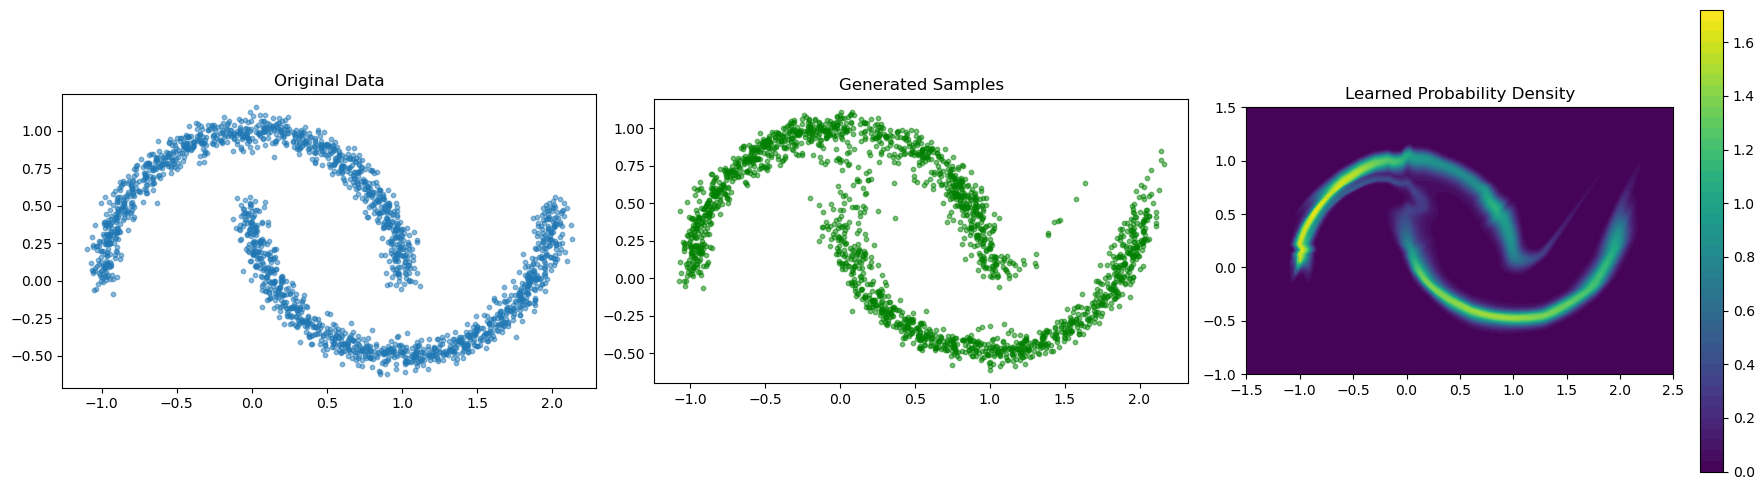

In [5]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import nnx
from sklearn.datasets import make_moons
from typing import Sequence
import distrax


# ##############################################################################
# 1. The Conditioner
# ##############################################################################
class MLP(nnx.Module):
    def __init__(self, features: Sequence[int], *, rngs: nnx.Rngs):
        self.layers = [
            nnx.Linear(din, dout, rngs=rngs)
            for din, dout in zip(features[:-1], features[1:])
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers[:-1]:
            x = nnx.relu(layer(x))
        x = self.layers[-1](x)
        return x


# ##############################################################################
# 2. The Corrected and Robust Distrax Flow Model
# ##############################################################################
class DistraxFlow(nnx.Module):
    def __init__(self, num_layers: int, din: int, dmid: int, *, rngs: nnx.Rngs):
        self.din = din
        keys = jax.random.split(rngs.params(), num_layers)

        # Store the learnable conditioners as a direct attribute.
        # nnx can scan this list and find all the nnx.Params.
        self.conditioners = [
            MLP(features=[din, dmid, din * 2], rngs=nnx.Rngs(params=keys[i]))
            for i in range(num_layers)
        ]

    def _make_distribution(self) -> distrax.Transformed:
        """A helper function to dynamically construct the distrax distribution."""

        def bijector_fn(params: jax.Array) -> distrax.Bijector:
            shift, log_scale = jnp.split(params, 2, axis=-1)
            return distrax.ScalarAffine(shift=shift, log_scale=jnp.tanh(log_scale))

        layers = []
        for i, conditioner in enumerate(self.conditioners):
            mask = jnp.arange(0, self.din) % 2 == (i % 2)
            layer = distrax.MaskedCoupling(
                mask=mask, bijector=bijector_fn, conditioner=conditioner
            )
            layers.append(layer)

        chain = distrax.Chain(layers)
        base_dist = distrax.MultivariateNormalDiag(
            loc=jnp.zeros(self.din), scale_diag=jnp.ones(self.din)
        )
        return distrax.Transformed(base_dist, chain)

    def log_prob(self, x: jax.Array) -> jax.Array:
        """Builds the distribution on-the-fly and computes log_prob."""
        dist = self._make_distribution()
        return dist.log_prob(x)

    def sample(self, num_samples: int, *, rngs: nnx.Rngs) -> jax.Array:
        """Builds the distribution on-the-fly and samples from it."""
        dist = self._make_distribution()
        return dist.sample(seed=rngs.next(), sample_shape=num_samples)


# ##############################################################################
# 3. Training and Main Script (Unchanged)
# ##############################################################################
@nnx.jit
def train_step(
    model: DistraxFlow, optimizer: nnx.Optimizer, batch: jax.Array
) -> jax.Array:
    def loss_fn(model: DistraxFlow) -> jax.Array:
        log_probs = model.log_prob(batch)
        return -jnp.mean(log_probs)

    grads = nnx.grad(loss_fn)(model)
    optimizer.update(grads)
    return loss_fn(model)


if __name__ == "__main__":
    key = jax.random.key(42)
    model_key, sample_key = jax.random.split(key)

    x_data, _ = make_moons(n_samples=2000, noise=0.05)

    flow_model = DistraxFlow(num_layers=8, din=2, dmid=64, rngs=nnx.Rngs(model_key))

    optimizer = nnx.Optimizer(
        flow_model,
        optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.adam(learning_rate=1e-3),
        ),
    )

    print("--- Starting Training ---")
    for i in range(2001):
        loss = train_step(flow_model, optimizer, x_data)
        if i % 200 == 0:
            print(f"Step {i:04d} | NLL Loss: {loss:.4f}")
    print("--- Training Complete ---")

    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(x_data[:, 0], x_data[:, 1], alpha=0.5, s=10)
    axes[0].set_title("Original Data")
    axes[0].set_aspect("equal", "box")

    samples = flow_model.sample(num_samples=2000, rngs=nnx.Rngs(sample_key))
    axes[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, color="g")
    axes[1].set_title("Generated Samples")
    axes[1].set_aspect("equal", "box")

    grid_size = 200
    x_range = jnp.linspace(-1.5, 2.5, grid_size)
    y_range = jnp.linspace(-1.0, 1.5, grid_size)
    xx, yy = jnp.meshgrid(x_range, y_range)
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    log_probs = flow_model.log_prob(grid_points)
    probs = jnp.exp(log_probs).reshape(grid_size, grid_size)

    contour = axes[2].contourf(xx, yy, probs, levels=50, cmap="viridis")
    axes[2].set_title("Learned Probability Density")
    axes[2].set_aspect("equal", "box")
    plt.colorbar(contour, ax=axes[2])

    plt.tight_layout()
    plt.show()

--- Starting Training ---
Step 0000 | NLL Loss: 5.8406
Step 0500 | NLL Loss: 1.6113
Step 1000 | NLL Loss: 1.5353
Step 1500 | NLL Loss: 1.5621
Step 2000 | NLL Loss: 1.5325
Step 2500 | NLL Loss: 1.5547
Step 3000 | NLL Loss: 1.5125
Step 3500 | NLL Loss: 1.5231
Step 4000 | NLL Loss: 1.5044
Step 4500 | NLL Loss: 1.4949
Step 5000 | NLL Loss: 1.4891
--- Training Complete ---


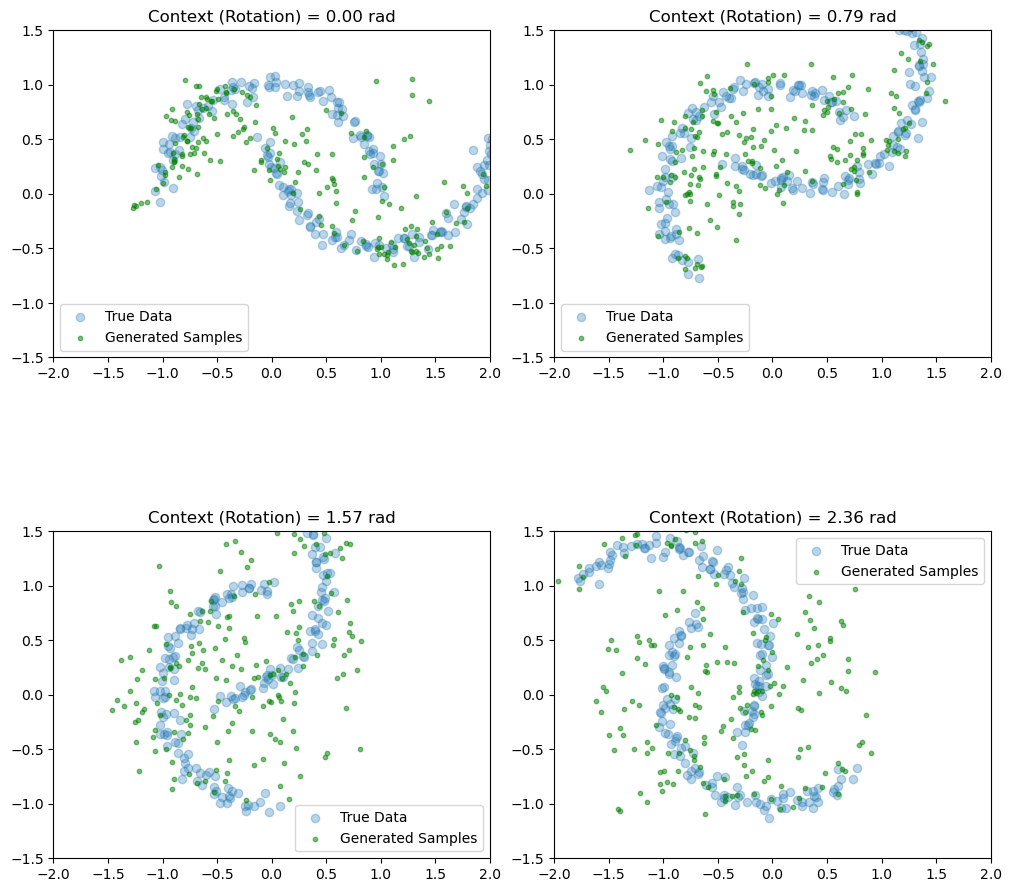

In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax import nnx
from sklearn.datasets import make_moons
from typing import Sequence
import distrax

# ##############################################################################
# 1. Data Simulation
# ##############################################################################


def make_conditional_moons(
    context: jax.Array, n_samples: int, noise: float, key: jax.Array
) -> jax.Array:
    """Generates a 'two moons' dataset rotated by an angle from the context."""
    moons, _ = make_moons(n_samples=n_samples, noise=noise, random_state=0)

    cos_c = jnp.cos(context)
    sin_c = jnp.sin(context)
    rotation_matrix = jnp.array([[cos_c, -sin_c], [sin_c, cos_c]]).squeeze()

    return jnp.dot(moons, rotation_matrix.T)


# ##############################################################################
# 2. Model Definition
# ##############################################################################


class ConditionalMLP(nnx.Module):
    """An MLP that takes a context variable as an additional input."""

    def __init__(self, features: Sequence[int], *, rngs: nnx.Rngs):
        self.layers = [
            nnx.Linear(din, dout, rngs=rngs)
            for din, dout in zip(features[:-1], features[1:])
        ]

    def __call__(self, x: jax.Array, context: jax.Array) -> jax.Array:
        context = jnp.broadcast_to(context, (*x.shape[:-1], context.shape[-1]))
        combined_input = jnp.concatenate([x, context], axis=-1)

        for layer in self.layers[:-1]:
            combined_input = nnx.relu(layer(combined_input))
        return self.layers[-1](combined_input)


class ConditionalFlow(nnx.Module):
    """A conditional normalizing flow using coupling layers."""

    def __init__(
        self,
        num_layers: int,
        data_dim: int,
        context_dim: int,
        hidden_dim: int,
        *,
        rngs: nnx.Rngs,
    ):
        self.data_dim = data_dim
        keys = jax.random.split(rngs.params(), num_layers)

        self.conditioners = [
            ConditionalMLP(
                features=[
                    # Corrected: The input to the conditioner's MLP is the full
                    # data dimension plus the context dimension.
                    data_dim + context_dim,
                    hidden_dim,
                    (data_dim - data_dim // 2) * 2,
                ],
                rngs=nnx.Rngs(params=keys[i]),
            )
            for i in range(num_layers)
        ]

    def _make_distribution(self, context: jax.Array) -> distrax.Transformed:
        """Helper to dynamically construct the conditional distribution."""

        def bijector_fn(params: jax.Array) -> distrax.Bijector:
            shift, log_scale = jnp.split(params, 2, axis=-1)
            return distrax.ScalarAffine(shift=shift, log_scale=jnp.tanh(log_scale))

        layers = []
        for i, conditioner in enumerate(self.conditioners):
            mask = jnp.arange(0, self.data_dim) % 2 == (i % 2)

            layer = distrax.MaskedCoupling(
                mask=mask,
                bijector=bijector_fn,
                conditioner=lambda x: conditioner(x, context=context),
            )
            layers.append(layer)

        chain = distrax.Chain(layers)
        base_dist = distrax.MultivariateNormalDiag(
            loc=jnp.zeros(self.data_dim), scale_diag=jnp.ones(self.data_dim)
        )
        return distrax.Transformed(base_dist, chain)

    def log_prob(self, value: jax.Array, context: jax.Array) -> jax.Array:
        dist = self._make_distribution(context)
        return dist.log_prob(value)

    def sample(
        self, num_samples: int, context: jax.Array, *, rngs: nnx.Rngs
    ) -> jax.Array:
        dist = self._make_distribution(context)
        return dist.sample(seed=rngs.next(), sample_shape=num_samples)


# ##############################################################################
# 3. Training and Main Script
# ##############################################################################
@nnx.jit
def train_step(
    model: ConditionalFlow,
    optimizer: nnx.Optimizer,
    value: jax.Array,
    context: jax.Array,
) -> jax.Array:
    def loss_fn(model: ConditionalFlow) -> jax.Array:
        log_probs = model.log_prob(value, context)
        return -jnp.mean(log_probs)

    grads = nnx.grad(loss_fn)(model)
    optimizer.update(grads)
    return loss_fn(model)


if __name__ == "__main__":
    key = jax.random.key(42)

    n_samples_per_context = 500
    n_contexts = 10
    key, data_key, model_key = jax.random.split(key, 3)

    contexts = jnp.linspace(0, jnp.pi, n_contexts).reshape(-1, 1)

    all_values = []
    all_contexts = []
    for c in contexts:
        all_values.append(
            make_conditional_moons(c, n_samples_per_context, 0.05, data_key)
        )
        all_contexts.append(jnp.tile(c, (n_samples_per_context, 1)))

    training_values = jnp.concatenate(all_values)
    training_contexts = jnp.concatenate(all_contexts)

    flow_model = ConditionalFlow(
        num_layers=8, data_dim=2, context_dim=1, hidden_dim=64, rngs=nnx.Rngs(model_key)
    )
    optimizer = nnx.Optimizer(
        flow_model,
        optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.adam(learning_rate=1e-3),
        ),
    )

    print("--- Starting Training ---")
    for i in range(5001):
        loss = train_step(flow_model, optimizer, training_values, training_contexts)
        if i % 500 == 0:
            print(f"Step {i:04d} | NLL Loss: {loss:.4f}")
    print("--- Training Complete ---")

    # --- Visualization ---
    key, sample_key = jax.random.split(key)
    viz_contexts = jnp.array([0, jnp.pi / 4, jnp.pi / 2, 3 * jnp.pi / 4]).reshape(-1, 1)

    # --- CORRECTED CODE PART 1: Split the key for each plot ---
    # Create 4 unique keys for the 4 visualization plots
    viz_keys = jax.random.split(sample_key, 4)
    # --- END OF CORRECTION ---

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    axes = axes.flatten()

    for i, (ax, c) in enumerate(zip(axes, viz_contexts)):
        true_data = make_conditional_moons(c, 200, 0.05, data_key)
        ax.scatter(true_data[:, 0], true_data[:, 1], alpha=0.3, label="True Data")

        # --- CORRECTED CODE PART 2: Use the unique subkey for this plot ---
        samples = flow_model.sample(200, context=c, rngs=nnx.Rngs(viz_keys[i]))
        # --- END OF CORRECTION ---

        ax.scatter(
            samples[:, 0],
            samples[:, 1],
            alpha=0.5,
            s=10,
            color="g",
            label="Generated Samples",
        )

        ax.set_title(f"Context (Rotation) = {c.item():.2f} rad")
        ax.legend()
        ax.set_aspect("equal", "box")
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.5, 1.5)

    plt.show()